In [2]:
import pickle
import datetime as dt
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import numpy as np

Finding the repository we are working in so later is easier to read/write files

In [3]:
dir_path = os.path.abspath('')
data_path = os.path.join(dir_path, 'data')

In [4]:
def date_to_weekday(day, month, year):
    parsed_date = dt.date(int(year), int(month), int(day))
    weekday_map = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}
    return((weekday_map[parsed_date.weekday()]))

In [5]:
def date_to_week_number(day, month, year):
    week_number = dt.date(year, month, day).isocalendar()[1]
    return(week_number)

In [6]:
def mutual_keys_of_multiple_dictionaries(list_of_dictionaries):
    s = set(list_of_dictionaries[0].keys())
    for i in range(len(list_of_dictionaries)):
        s = s.intersection(set(list_of_dictionaries[i].keys()))
    return(s)

In [7]:
m_to_h_data_converted_format = os.path.join(data_path, 'kunta_utf-8_trimmed_include_both_swedish_and_Finnish.csv')

This function will read the file `kunta_utf-8_trimmed_include_both_swedish_and_Finnish.csv` and generate 2 dictionaries. The first one will map the hospital care districts (HCD) to the municipalities. The second one will do the inverse order.

In [8]:
def map_municiplaities_to_hospital_district_areas(data_path):
    line_counter = 0
    m_to_h = {}
    h_to_m = {}
    with open(data_path, 'r') as data:
        for line in data:
            line_counter += 1
            ### the enteries start from 6th line
            if line_counter > 5:
                fields = line.strip().split(';')
                municipality_string = fields[1]
                municipality = municipality_string[1:-1]
                hospital_string = fields[3]
                hospital_district = hospital_string[1:-1]
                m_to_h[municipality] = hospital_district
                if hospital_district not in h_to_m.keys():
                    h_to_m[hospital_district] = set()
                h_to_m[hospital_district].add(municipality)
    return h_to_m, m_to_h

Storing the results of running the function

In [9]:
h_to_m, m_to_h = map_municiplaities_to_hospital_district_areas(m_to_h_data_converted_format)

In [10]:
def saved_results_to_estimation_book(path_to_saved_results, number_of_header_lines = 1):
    #This function reads saved results in the format of CSV files into python dictionaries
    estimation_book = {}
    with open(path_to_saved_results, 'r') as data:
        line_counter = 0
        for line in data:
            line_counter += 1
            if line_counter > number_of_header_lines:
                fields = line.strip().split(',')
                origin_str = fields[5]
                destination_str = fields[6]
                hour_str = fields[4]
                date_str = fields[2]
                year_str, month_str, day_str = date_str.split('-')
                key = (origin_str, destination_str, hour_str, day_str, month_str, year_str)
                flow = float(fields[0])
                estimation_book[key] = flow
    return estimation_book

The grund truth data has four datapoints per day. On the other hand, the basic radiation and gravity model are static and Facabook + radiation has two datapoints per day. The following funtions make the estimations comparable.

In [14]:
def convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(od_book):
    #convert the od-matrix with temporal resolution of four datapoints per day to od-matrix with resolution of two datapoints per day
    merged_od_book = {}
    for key in od_book.keys():
        flow = od_book[key]
        o, d, hour, day, month, year = key[0], key[1], key[2], key[3], key[4], key[5]
        if hour == "0":
            key_to_add = (o, d, "6", day, month, year)
        elif hour == "6":
            key_to_add = key
        elif hour == "12":
            key_to_add = (o, d, "18", day, month, year)
        elif hour == "18":
            key_to_add = key
        if key_to_add not in merged_od_book:
            merged_od_book[key_to_add] = 0
        merged_od_book[key_to_add] += flow
    return merged_od_book

In [15]:
def convert_od_book_with_two_timebins_in_day_to_od_with_four_timebins_a_day(od_book):
    #convert the od-matrix with temporal resolution of two datapoints per day to od-matrix with resolution of four datapoints per day
    output_od_book = {}
    for key in od_book.keys():
        flow = od_book[key]
        o, d, hour, day, month, year = key[0], key[1], key[2], key[3], key[4], key[5]
        if hour == "6":
            output_od_book[(o, d, "0", day, month, year)] = flow/2
            output_od_book[(o, d, "6", day, month, year)] = flow/2
        elif hour == "18":
            output_od_book[(o, d, "12", day, month, year)] = flow/2
            output_od_book[(o, d, "18", day, month, year)] = flow/2
    return output_od_book

In [17]:
def reform_static_results_to_four_entries_per_day(static_radiation_prediction_book, telia_6h_book):
    reformed_radiation_book = {}
    for key in telia_6h_book.keys():
        o, d, hour, day, month, year = key[0], key[1], key[2], key[3], key[4], key[5]
        if hour == "6":
            reformed_radiation_book[key] = static_radiation_prediction_book[(o,d)]/2
        if hour == "12":
            reformed_radiation_book[key] = static_radiation_prediction_book[(o,d)]/2
        if hour == "18":
            reformed_radiation_book[key] = static_radiation_prediction_book[(d,o)]/2
        if hour == "0":
            reformed_radiation_book[key] = static_radiation_prediction_book[(d,o)]/2
    return reformed_radiation_book  

# Error Calculation

In [12]:
def absolute_error(book_of_original_values, book_of_predicted_values):
    # this function is used for calculating the error for the estimat related to a single orign, destination, and timestamp. 
    mutual_keys = set(book_of_original_values.keys()).intersection(set(book_of_predicted_values.keys()))
    dif_book = {}
    separeted_by_od = []
    separeted_by_date = []
    for tuple_key in mutual_keys:
        dif_book[tuple_key] = abs(book_of_original_values[tuple_key]- book_of_predicted_values[tuple_key])
    return(dif_book)

In [13]:
def countrywide_weekly_sum(distance_book):
    # this function sums all the values of error/ground-truth dictionary all over the country for each week.
    separated_by_week_number = {}
    for tuple_key in distance_book:
        origin = tuple_key[0]
        destination = tuple_key[1]
        if origin != destination:
            dif = distance_book[tuple_key]
            hour, day, month, year = int(tuple_key[2]), int(tuple_key[3]), int(tuple_key[4]), int(tuple_key[5])
            week_num = date_to_week_number(day, month, year)
            if week_num not in separated_by_week_number:
                separated_by_week_number[week_num] = []
            separated_by_week_number[week_num].append(dif)
    weekly_error_sum = {wn:sum(separated_by_week_number[wn]) for wn in separated_by_week_number.keys()}
    return(weekly_error_sum)

In [19]:
def calculate_the_normalized_error(ground_truth_6h_book, estimation_6_hour_book):
    # find the mutual keys
    mutual_keys = mutual_keys_of_multiple_dictionaries([estimation_6_hour_book, ground_truth_6h_book])
    filtered_ground_truth_book= {k:ground_truth_6h_book[k] for k in mutual_keys}
    filtered_estimation_book= {k:estimation_6_hour_book[k] for k in mutual_keys}
    filtered_ground_truth_12h = convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(filtered_ground_truth_book)
    filtered_estimation_12h = convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(filtered_estimation_book)
    absolute_error_12h = absolute_error(filtered_ground_truth_12h, filtered_estimation_12h)
    weekly_error_sum = countrywide_weekly_sum(absolute_error_12h)
    weekly_sum_ground_truth = countrywide_weekly_sum(filtered_ground_truth_12h)
    normalized_weekly_error = {k:weekly_error_sum[k]/weekly_sum_ground_truth[k] for k in weekly_error_sum.keys()}
    return normalized_weekly_error

# load the ground truth

In [20]:
telia_2020_path = "/.../telia_ground_truth.pkl" #because of privacy, unfortunately we can not share the ground-truth data.
with open(telia_2020_path, 'rb') as f:
    telia_hcd_od_book_2020 = pickle.load(f)

# Load the estimations

load estimations
convert it to temporal fromat so there is two datapoints per day
calculate the error

# Telecom + Road, daily and weekly

In [21]:
path = '/.../telia_road_estimation_daily_and_weekly_rhythms.csv'
telia_road_daily_and_weekly_estimation_book = saved_results_to_estimation_book(path)

In [23]:
normalized_weekly_error_sum_telia_road_day_week_12h = calculate_the_normalized_error(telia_hcd_od_book_2020, telia_road_daily_and_weekly_estimation_book)

## Telecom + Road, daily

In [26]:
path = '/.../telia_road_estimation_daily_rhythms.csv'
telia_road_daily_estimation_book = saved_results_to_estimation_book(path)

In [27]:
normalized_weekly_error_sum_telia_road_day_12h = calculate_the_normalized_error(telia_hcd_od_book_2020, telia_road_daily_estimation_book)

# Telecom + Road, Weekly

In [29]:
path = '/.../telia_road_estimation_weekly_rhythms.csv'
telia_road_weekly_estimation_book = saved_results_to_estimation_book(path)

In [30]:
normalized_weekly_error_sum_telia_road_week_12h = calculate_the_normalized_error(telia_hcd_od_book_2020, telia_road_weekly_estimation_book)

# Telecom + Road, Basic

In [32]:
path = '/.../telia_road_estimation_basic.csv'
telia_road_estimation_book = saved_results_to_estimation_book(path)

In [33]:
normalized_weekly_error_sum_telia_road_12h = calculate_the_normalized_error(telia_hcd_od_book_2020, telia_road_estimation_book)

## Static Radiation Model

In [35]:
radiation_static_commuters_book = {}
hospital_radiation_path = os.path.join(dir_path, 'results/radiation_model_commuters_hcd.pickle')
with open(hospital_radiation_path,'rb') as f:
     hospital_radiation_prediction = pickle.load(f)
len(hospital_radiation_prediction)

400

In [36]:
##reform static radiation to get temporal od
reformed_static_radiation_book = reform_static_results_to_four_entries_per_day(hospital_radiation_prediction, telia_hcd_od_book_2020)
len(reformed_static_radiation_book)

129014

In [37]:
normalized_weekly_error_sum_static_radiation = calculate_the_normalized_error(telia_hcd_od_book_2020, reformed_static_radiation_book)

## Static Gravity Model

In [41]:
# Load data (deserialize)
gravity_static_commuters_path = os.path.join(dir_path, 'results/gravity_model_commuters_hcd.pickle')
hospital_gravity_prediction = {}
with open(gravity_static_commuters_path, 'rb') as handle:
    hospital_gravity_prediction = pickle.load(handle) 

In [42]:
reformed_static_gravity_book = reform_static_results_to_four_entries_per_day(hospital_gravity_prediction, telia_hcd_od_book_2020)

In [43]:
normalized_weekly_error_sum_static_gravity = calculate_the_normalized_error(telia_hcd_od_book_2020, reformed_static_gravity_book)

## Radiation + road

In [47]:
road_radiation_pickle = os.path.join(dir_path, 'results/radiation_road_estimations.pkl')
with open(road_radiation_pickle, 'rb') as f:
    road_radiation_book = pickle.load(f)

In [48]:
normalized_weekly_error_sum_road_radiation_12h = calculate_the_normalized_error(telia_hcd_od_book_2020, road_radiation_book)

## Gravity + road

In [50]:
road_gravity_pickle = os.path.join(dir_path, 'results/dynamic_road_commuters_gravity_book.pkl')
with open(road_gravity_pickle, 'rb') as f:
    road_gravity_book = pickle.load(f)

In [52]:
normalized_weekly_error_sum_road_gravity_12h = calculate_the_normalized_error(telia_hcd_od_book_2020, road_gravity_book)

## facebook + radiation

In [55]:
facebook_commuters_radiation_pickle = os.path.join(dir_path, 'results/dynamic_commuters_radiation_facebook_hcd.pkl')
with open(facebook_commuters_radiation_pickle, 'rb') as f:
    facebook_commuters_radiation_book = pickle.load(f)

In [56]:
facebook_commuters_radiation_book_6h = convert_od_book_with_two_timebins_in_day_to_od_with_four_timebins_a_day(facebook_commuters_radiation_book)
normalized_weekly_error_sum_fb_radiation = calculate_the_normalized_error(telia_hcd_od_book_2020, facebook_commuters_radiation_book_6h)
del normalized_weekly_error_sum_fb_radiation[9]

## facebook + gravity 

In [58]:
facebook_commuters_gravity_pickle = os.path.join(dir_path, 'results/dynamic_commuters_gravity_facebook_hcd.pkl')
with open(facebook_commuters_gravity_pickle, 'rb') as f:
    facebook_commuters_gravity_book = pickle.load(f)

In [59]:
facebook_commuters_gravity_book_6h = convert_od_book_with_two_timebins_in_day_to_od_with_four_timebins_a_day(facebook_commuters_gravity_book)
normalized_weekly_error_sum_fb_gravity = calculate_the_normalized_error(telia_hcd_od_book_2020, facebook_commuters_gravity_book_6h)
del normalized_weekly_error_sum_fb_gravity[9]

## google + radiation

In [61]:
google_commuters_radiation_pickle = os.path.join(dir_path, 'results/dynamic_commuters_radiation_google_hcd.pkl')
with open(google_commuters_radiation_pickle, 'rb') as f:
    google_commuters_radiation_book = pickle.load(f)

In [62]:
google_commuters_radiation_book_6h = convert_od_book_with_two_timebins_in_day_to_od_with_four_timebins_a_day(google_commuters_radiation_book)
normalized_weekly_error_sum_google_radiation = calculate_the_normalized_error(telia_hcd_od_book_2020, google_commuters_radiation_book_6h)
del normalized_weekly_error_sum_google_radiation[7]

## google + gravity

In [64]:
google_commuters_gravity_pickle = os.path.join(dir_path, 'results/dynamic_commuters_gravity_google_hcd.pkl')
with open(google_commuters_gravity_pickle, 'rb') as f:
    google_commuters_gravity_book = pickle.load(f)

In [65]:
google_commuters_gravity_book_6h = convert_od_book_with_two_timebins_in_day_to_od_with_four_timebins_a_day(google_commuters_gravity_book)
normalized_weekly_error_sum_google_gravity = calculate_the_normalized_error(telia_hcd_od_book_2020, google_commuters_gravity_book_6h)
del normalized_weekly_error_sum_google_gravity[7]

# Telecom Baseline: median of 2019 Telia

In [67]:
estimation_trained_by_telia = '/.../median_of_2019_as_a_baseline.csv'
baseline_estimation_book = saved_results_to_estimation_book(estimation_trained_by_telia)

In [68]:
normalized_weekly_error_sum_telia_baseline_12h = calculate_the_normalized_error(telia_hcd_od_book_2020, baseline_estimation_book)

# weekly visualization

In [73]:
def plot_timeline_of_weekly_error(list_of_error_books, model_names, color_list, marker_list, y_lab, y_max, path_to_save = None, file_name = None):
    f = plt.figure(figsize = (19,12))
    ax = f.add_subplot(1,1,1)
    
    ax.fill_between(x=[12.5, 20.4], y1=0, y2=y_max, color='gray', alpha=0.1 )
    ax.axvline(x=12.5, ls = ":", color = "black", alpha = 0.7)
    ax.axvline(x=20.4, ls = ":", color = "black", alpha = 0.7)
    ax.fill_between(x=[13.7, 17], y1=0, y2=y_max, color='pink', alpha=0.1 )
    ax.axvline(x=13.7, color = "red", alpha = 0.7)
    ax.axvline(x=17, color = "red", alpha = 0.7)
    
    
    for i in range(len(list_of_error_books)):
        error_book = list_of_error_books[i]
        w_list = sorted([w for w in error_book.keys()])
        x = [w + 0.5 for w in w_list]
        y = [error_book[week] for week in w_list]
        ax.plot(x, y, label = model_names[i] , ls = '-', markersize = 18, color = color_list[i], marker = marker_list[i], alpha = 0.7)
    ax.legend(fontsize = "24")
    ax.set_xlabel("Week", fontsize = "28")
    ax.set_ylabel(y_lab, fontsize = "28")
    #ax.set_xlim(4,24)
    ax.set_xticks(range(5,23))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.ticklabel_format(style='plain')
    plt.tight_layout()
    ax.set_ylim(0,y_max)
    
    if path_to_save != None and file_name != None:
        plt.savefig(path_to_save + "/" + file_name + ".png", dpi=300)
        plt.savefig(path_to_save + "/" + file_name + ".pdf", dpi=300)
    plt.show()
    return(None)
        

In [74]:
def plot_timeline_of_weekly_errors_and_interventions(list_of_error_books, model_names, color_list, marker_list, ls_list, opacity_list, y_lab, y_max, path_to_save = None, file_name = None):
    f = plt.figure()
    fig, ax = plt.subplots(figsize = (19,12))
    
    ax.fill_between(x=[12.5, 20.4], y1=0, y2=1.7, color='gray', alpha=0.1 )
    ax.axvline(x=12.5, ls = ":", color = "black", alpha = 0.7)
    ax.axvline(x=20.4, ls = ":", color = "black", alpha = 0.7)
    ax.fill_between(x=[13.7, 17], y1=0, y2=1.7, color='pink', alpha=0.1 )
    ax.axvline(x=13.7, color = "red", alpha = 0.7)
    ax.axvline(x=17, color = "red", alpha = 0.7)
    

    for i in range(len(list_of_error_books)):
        error_book = list_of_error_books[i]
        w_list = sorted([w for w in error_book.keys()])
        x = [w + 0.5 for w in w_list]
        y = [error_book[week] for week in w_list]
        ax.plot(x, y, label = model_names[i], linewidth = 2.5, ls = ls_list[i], markersize = 16, color = color_list[i], marker = marker_list[i], alpha = opacity_list[i])
    ax.set_ylabel(y_lab, fontsize = "28")
    ax.set_xlabel("Week", fontsize = "28")
    ax.set_xticks(range(5,23))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.ticklabel_format(style='plain')
    ax.set_ylim(0,y_max)
    ax.legend(fontsize = "22.5", ncol=3, loc='upper left')
    plt.tight_layout()
    
    if path_to_save != None and file_name != None:
        plt.savefig(path_to_save + "/" + file_name + ".png", dpi=300)
        plt.savefig(path_to_save + "/" + file_name + ".pdf", dpi=300)
    plt.show()
    return(None)

In [75]:
def plot_timeline_of_weekly_errors_and_interventions_unnormalized(list_of_error_books, model_names, color_list, marker_list, ls_list, opacity_list, y_lab, y_max, path_to_save = None, file_name = None):
    f = plt.figure()
    fig, ax = plt.subplots(figsize = (19,12))
    
    ax.fill_between(x=[12.5, 20.4], y1=0, y2=y_max, color='gray', alpha=0.1 )
    ax.axvline(x=12.5, ls = ":", color = "black", alpha = 0.7)
    ax.axvline(x=20.4, ls = ":", color = "black", alpha = 0.7)
    ax.fill_between(x=[13.7, 17], y1=0, y2=y_max, color='pink', alpha=0.1 )
    ax.axvline(x=13.7, color = "red", alpha = 0.7)
    ax.axvline(x=17, color = "red", alpha = 0.7)
    
    
    for i in range(len(list_of_error_books)):
        error_book = list_of_error_books[i]
        w_list = sorted([w for w in error_book.keys()])
        x = [w + 0.5 for w in w_list]
        y = [error_book[week] for week in w_list]
        ax.plot(x, y, label = model_names[i], linewidth = 2.5, ls = ls_list[i], markersize = 16, color = color_list[i], marker = marker_list[i], alpha = opacity_list[i])
    ax.set_ylabel(y_lab, fontsize = "28")
    ax.set_xlabel("Week", fontsize = "28")
    ax.set_xticks(range(5,23))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.ticklabel_format(style='plain')
    ax.set_ylim(0,y_max)
    ax.legend(fontsize = "22.5", ncol=3, loc='upper left')
    plt.tight_layout()
    
    if path_to_save != None and file_name != None:
        plt.savefig(path_to_save + "/" + file_name + ".png", dpi=300)
        plt.savefig(path_to_save + "/" + file_name + ".pdf", dpi=300)
    plt.show()
    return(None)

# effect of making daily and weekly rythms into account

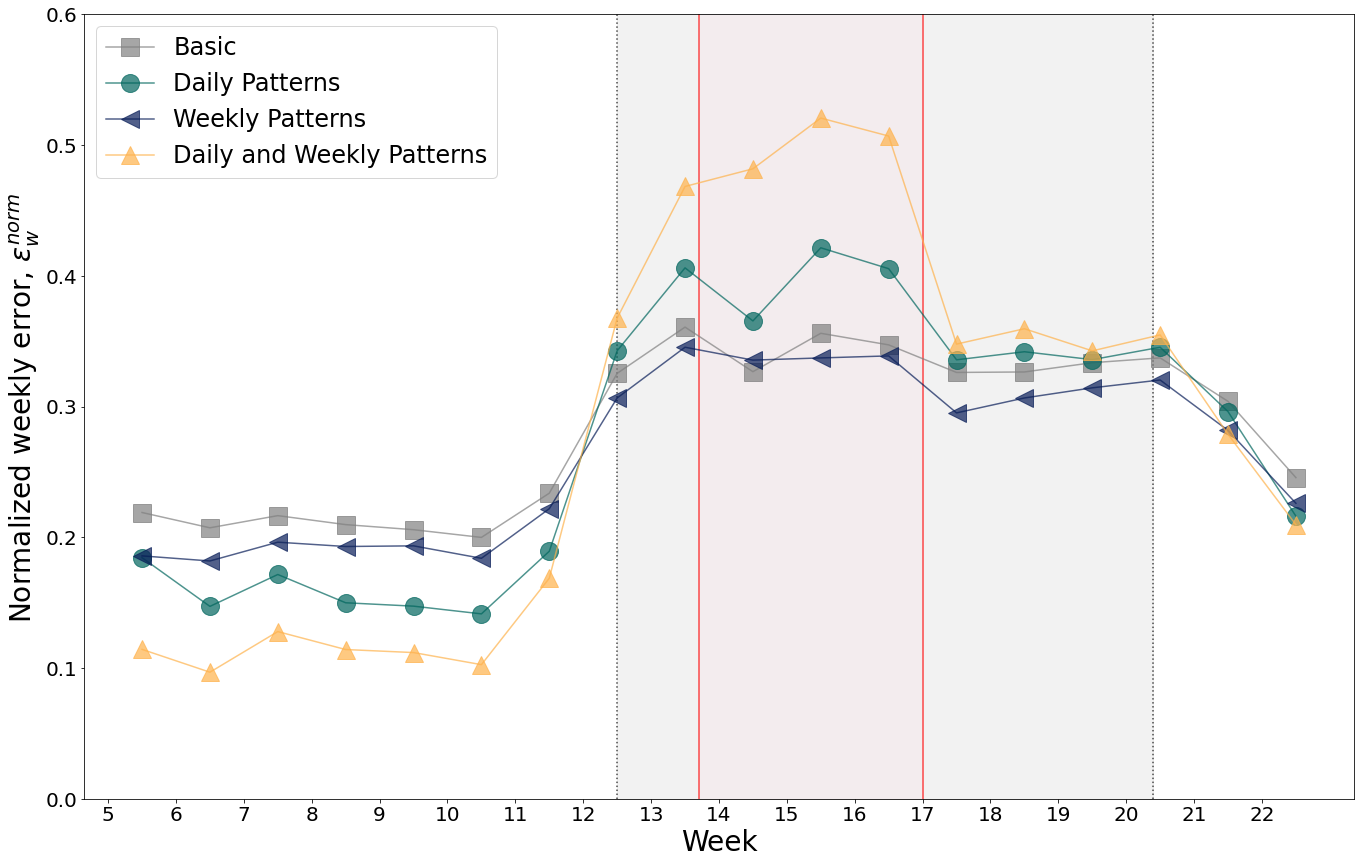

In [78]:
%matplotlib inline
model_names_list = ["Basic", "Daily Patterns", "Weekly Patterns", "Daily and Weekly Patterns"]
color_list = ["gray", "#01665e", "#081d58", "#feb24c"]
marker_list = ['s', 'o',  '<',  '^']
error_books_list = [normalized_weekly_error_sum_telia_road_12h, normalized_weekly_error_sum_telia_road_day_12h, normalized_weekly_error_sum_telia_road_week_12h, normalized_weekly_error_sum_telia_road_day_week_12h] 
path_for_saving = "/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/plots/comparison_of_weekly_error"
file_save_name = "different_temporal_configs"
plot_timeline_of_weekly_error(error_books_list, model_names_list, color_list, marker_list, 'Normalized weekly error, $\epsilon_{w}^{norm}$ ', 0.6, path_for_saving, file_save_name)

In [81]:
averages = [np.mean(list(normalized_weekly_error_sum_telia_road_12h.values())), np.mean(list(normalized_weekly_error_sum_telia_road_day_12h.values())), np.mean(list(normalized_weekly_error_sum_telia_road_week_12h.values())), np.mean(list(normalized_weekly_error_sum_telia_road_day_week_12h.values()))]
model_names_list = ["Basic", "Daily Patterns", "Weekly Patterns", "Daily and Weekly Patterns"]
print(model_names_list)
print(averages)

['Basic', 'Daily Patterns', 'Weekly Patterns', 'Daily and Weekly Patterns']
[0.2823043626384154, 0.2746695406011946, 0.2646791406095639, 0.2819598931080878]


# How much does using road traffic data decrease the error of the static model?

In [82]:
relative_list = []
for key in normalized_weekly_error_sum_road_radiation_12h.keys():
    print(key)
    print(normalized_weekly_error_sum_road_radiation_12h[key]/normalized_weekly_error_sum_static_radiation[key])
    relative_list.append(normalized_weekly_error_sum_road_radiation_12h[key]/normalized_weekly_error_sum_static_radiation[key])
print(np.average(relative_list))

17
0.9366434926350353
20
0.9291743570804495
11
0.8807245581430211
8
0.8235919629026822
14
0.7099507245673092
5
0.8669777071183867
6
0.8534143540630887
7
0.8102277156747902
21
0.9146201204700586
15
0.6911846510578541
16
0.8019423910176477
12
0.9913538935924533
10
0.8011348744023197
18
0.9556935796779413
22
0.7807547391876709
19
0.909457512659652
9
0.7823995982003666
13
0.829628043992013
0.8482707931357079


In [83]:
relative_list = []
for key in normalized_weekly_error_sum_road_gravity_12h.keys():
    print(key)
    print(normalized_weekly_error_sum_road_gravity_12h[key]/normalized_weekly_error_sum_static_gravity[key])
    relative_list.append(normalized_weekly_error_sum_road_gravity_12h[key]/normalized_weekly_error_sum_static_gravity[key])
print(np.average(relative_list))

17
0.6968796279546743
20
0.6999929426817241
11
0.6831623585441033
8
0.6565064730450098
14
0.6336904023904334
5
0.6925357023794607
6
0.6496252996633473
7
0.6820345265321106
21
0.6972472762883837
15
0.6303029331465957
16
0.7158291273098011
12
0.7697183458145869
10
0.6350072641596749
18
0.7419682311054229
22
0.5841777581652257
19
0.6735934879742248
9
0.6602810127234412
13
0.7443824430683906
0.6803852896081451


## Normalized

<Figure size 432x288 with 0 Axes>

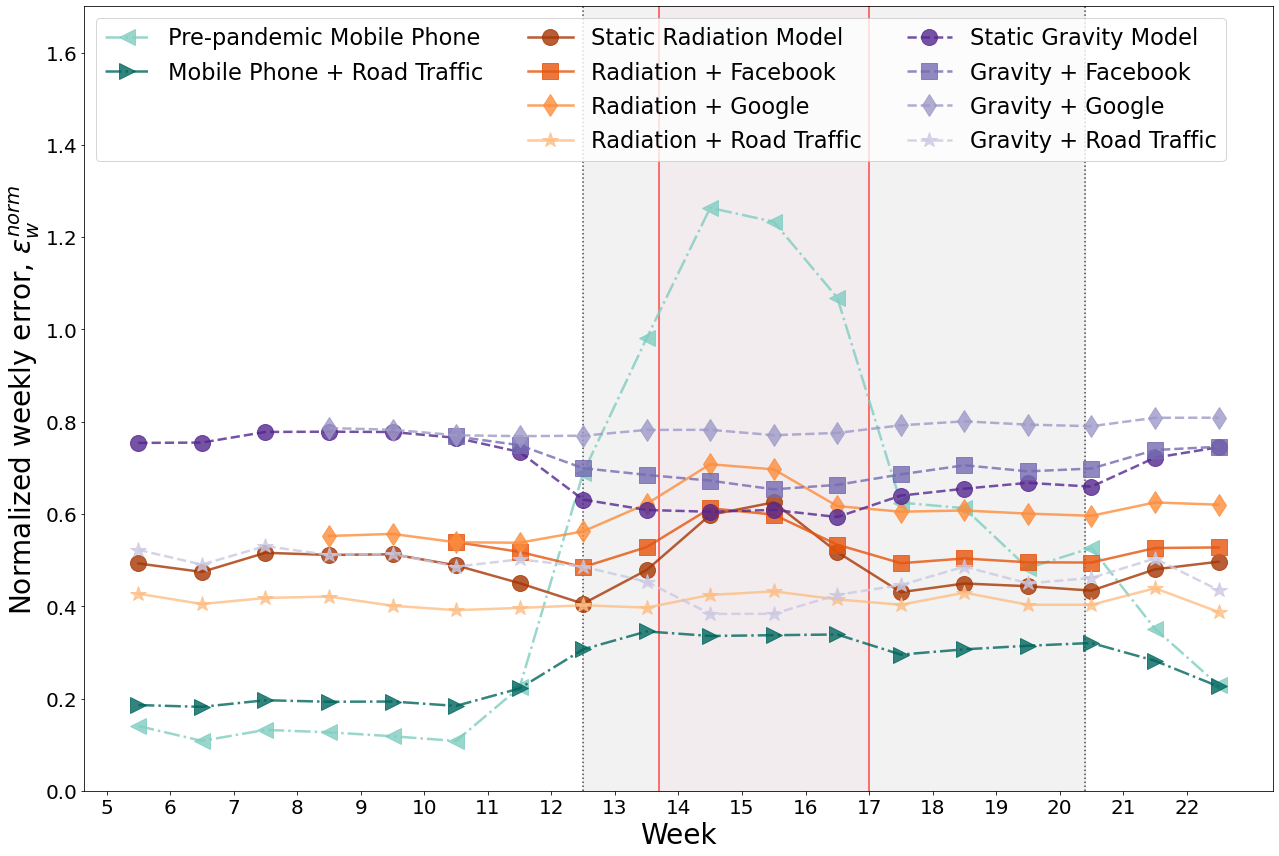

In [84]:
model_names_list = ["Pre-pandemic Mobile Phone", "Mobile Phone + Road Traffic", " ", " ",
                    "Static Radiation Model", "Radiation + Facebook",  "Radiation + Google", "Radiation + Road Traffic",
                    "Static Gravity Model", "Gravity + Facebook",  "Gravity + Google", "Gravity + Road Traffic"]
marker_list = ['<', '>', ".", ".", 'o', 's', 'd', '*', 'o', 's', 'd', '*']
opacity_list = [0.8, 0.8, 0, 0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]

color_list = ["#80cdc1", "#01665e", "black", "black", "#a63603", "#e6550d", "#fd8d3c", "#fdbe85", "#54278f", "#756bb1", "#9e9ac8", "#cbc9e2"]
normalized_error_books_list = [normalized_weekly_error_sum_telia_baseline_12h, normalized_weekly_error_sum_telia_road_week_12h, normalized_weekly_error_sum_telia_baseline_12h, normalized_weekly_error_sum_telia_baseline_12h,
                               normalized_weekly_error_sum_static_radiation, normalized_weekly_error_sum_fb_radiation, normalized_weekly_error_sum_google_radiation, normalized_weekly_error_sum_road_radiation_12h,
                               normalized_weekly_error_sum_static_gravity, normalized_weekly_error_sum_fb_gravity, normalized_weekly_error_sum_google_gravity, normalized_weekly_error_sum_road_gravity_12h]
linestyle_list = ["dashdot", "dashdot", "solid", "solid", "solid", "solid", "solid", "solid", "dashed", "dashed", "dashed", "dashed"]


path_for_saving = "/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/plots/comparison_of_weekly_error"
file_save_name = "normalized_all_models_interventions_highlighted"

plot_timeline_of_weekly_errors_and_interventions(normalized_error_books_list, model_names_list, color_list, marker_list, linestyle_list, opacity_list, "Normalized weekly error, $\epsilon_{w}^{norm}$", 1.7, path_for_saving, file_save_name)
